In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'DKK=X'
numbers_in_currency = 'USD'
share_name = 'MAERSK-B.CO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-06-30,11949,0,11949,2304,3411,7147,1307,13306,0,...,0,0,2735,11262,11272,28498,1749,-1908,21.98,2014-08-04
1,2014-09-30,12169,0,12169,1495,5163,6928,1305,14340,0,...,0,0,2690,11880,11609,29428,2722,-2698,21.98,2014-11-04
2,2014-12-31,11715,0,11715,189,3507,4077,1139,16225,0,...,0,0,1412,9602,10913,26619,2416,-1911,21.98,2015-02-09
3,2015-03-31,10547,0,10547,1572,3078,11036,1034,16103,0,...,0,0,1336,15627,10369,32053,1950,-1985,21.55,2015-05-05
4,2015-06-30,10526,0,10526,1086,1780,6413,977,10608,0,...,0,0,1083,9161,10573,25779,1777,-1893,21.55,2015-08-04


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)

## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2023-03-31,2023-05-05,17.57,98548.866735,0.0,98548.866735,16113.818359,80825.747532,131872.492820,10273.166160,...,593013.487516,0.0,0.0,22453.908751,103654.234928,25485.221115,213218.488470,36895.996492,-5812.905633,6.936642
36,2023-06-30,2023-08-04,17.57,88859.896382,0.0,88859.896382,10173.596082,71310.956266,133939.805317,10146.229314,...,571281.286407,0.0,0.0,20737.168612,85185.907749,25184.268446,192716.781743,18972.012062,-5049.168735,6.841692
37,2023-09-30,2023-11-04,17.57,83060.442629,0.0,83060.442629,3793.839988,52250.900920,153910.746812,12114.265233,...,571534.461320,0.0,0.0,20338.817265,87785.622397,27597.789083,195752.556067,9477.751884,-5608.582943,6.848087
38,2023-12-31,2024-02-09,17.57,81406.557563,0.0,81406.557563,-3161.688974,46461.574161,144723.539392,11495.790174,...,569242.685963,0.0,0.0,19739.755505,85913.351057,28905.880119,194624.143666,832.023414,-8673.844094,6.933528
39,2024-03-31,2024-04-29,17.57,84800.819462,0.0,84800.819462,1427.646333,50551.034831,136546.135360,11283.896981,...,560062.911085,0.0,0.0,18881.995495,86544.195273,35663.703596,193727.489220,7515.734303,-4845.761112,6.863684


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-08-04,6023.980957,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.598461,0.401539,0.0,0.0,0.0,0.0,1.0,0.192819,0.0,0.0
1,2014-08-11,6328.510254,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.598461,0.401539,0.0,0.0,0.0,0.0,1.0,0.192819,0.0,0.0
2,2014-08-18,6823.370117,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.598461,0.401539,0.0,0.0,0.0,0.0,1.0,0.192819,0.0,0.0
3,2014-08-25,6756.755371,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.598461,0.401539,0.0,0.0,0.0,0.0,1.0,0.192819,0.0,0.0
4,2014-09-01,6994.669434,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.598461,0.401539,0.0,0.0,0.0,0.0,1.0,0.192819,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-08-04,6023.980957,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.0,1.0,0.192819,0.0,0.0,inf,0.573058,inf,inf,inf
1,2014-08-11,6328.510254,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.0,1.0,0.192819,0.0,0.0,inf,0.602027,inf,inf,inf
2,2014-08-18,6823.370117,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.0,1.0,0.192819,0.0,0.0,inf,0.649103,inf,inf,inf
3,2014-08-25,6756.755371,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.0,1.0,0.192819,0.0,0.0,inf,0.642766,inf,inf,inf
4,2014-09-01,6994.669434,2014-06-30,65001.199283,0.0,10511.998325,21.98,0.0,0.0,18555.451565,...,0.0,1.0,0.192819,0.0,0.0,inf,0.665399,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

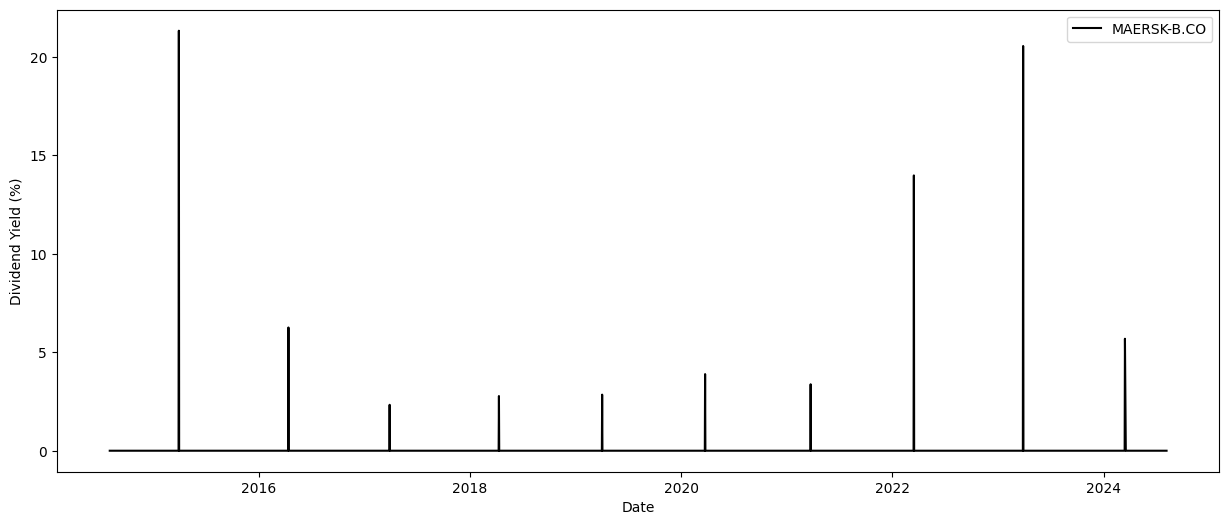

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.274428
share_price      1.000000
Name: share_price, dtype: float64


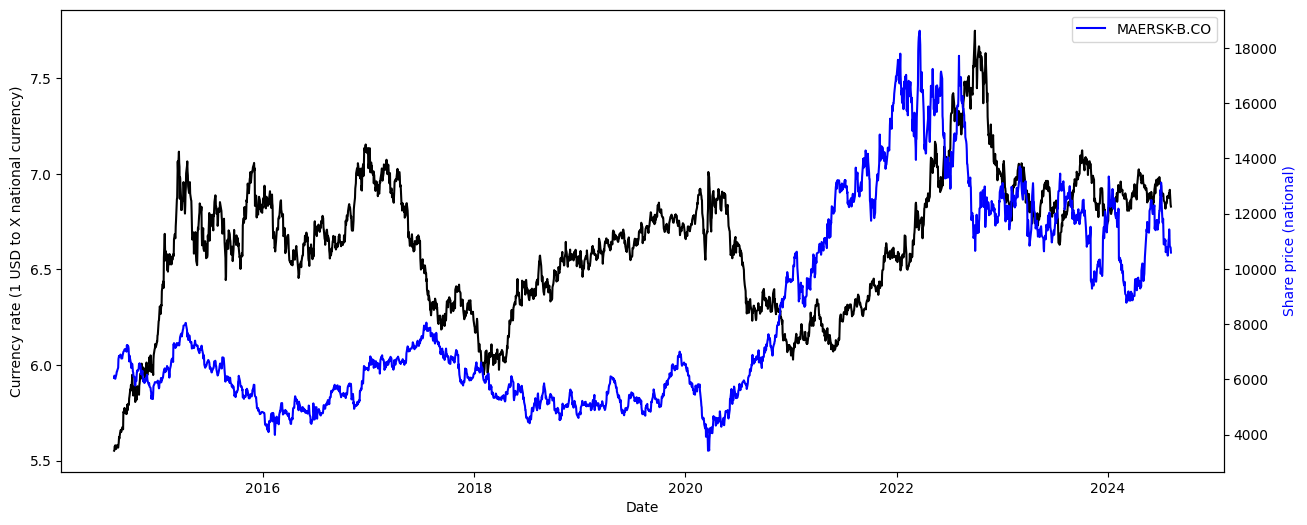

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

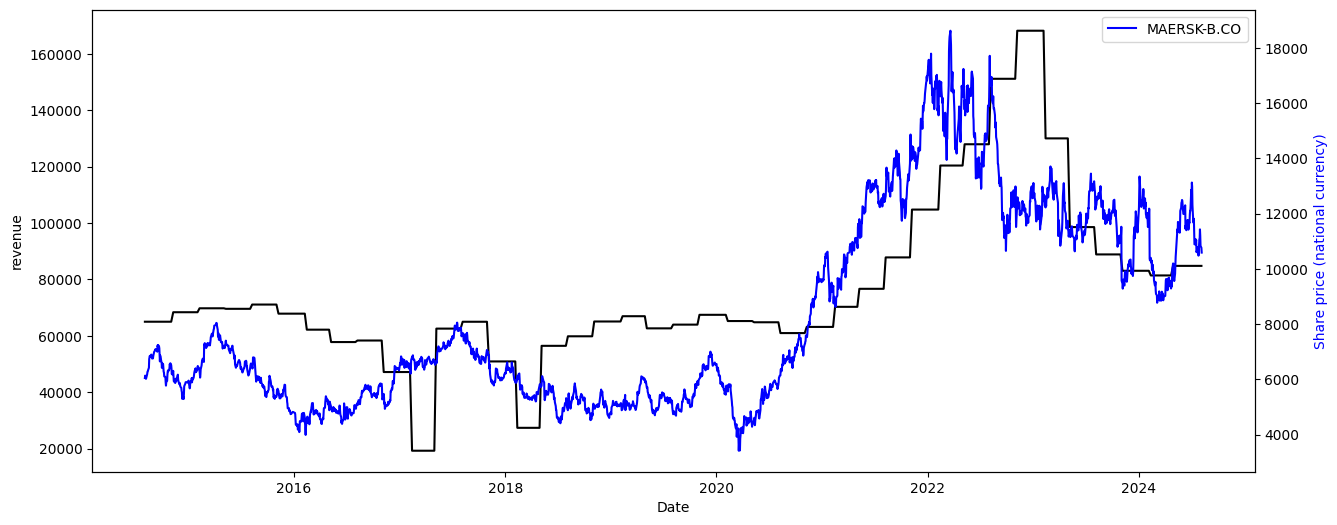

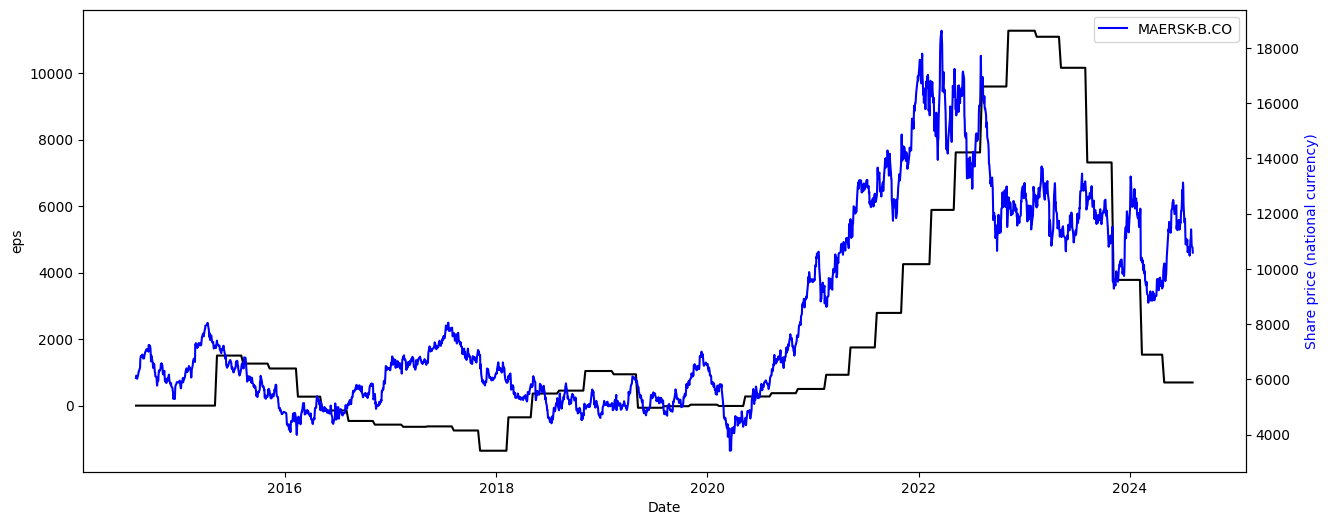

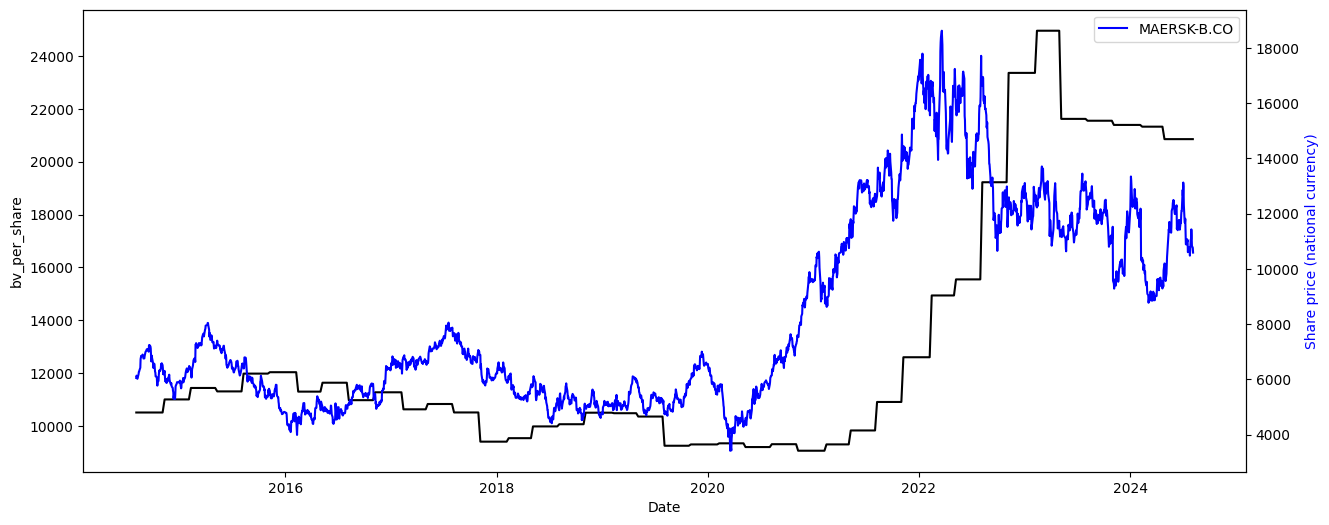

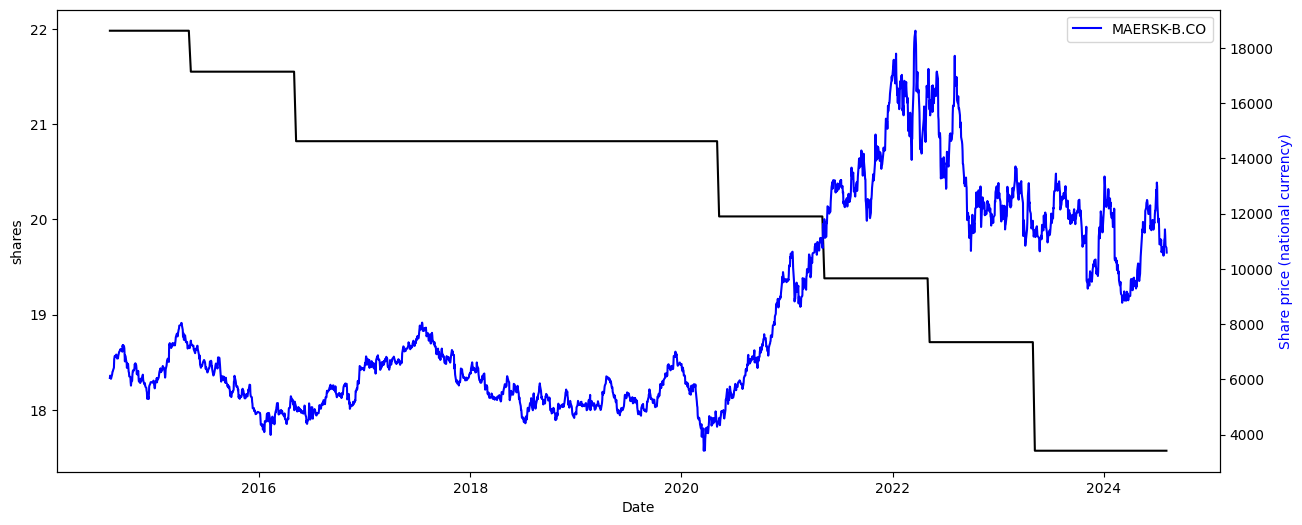

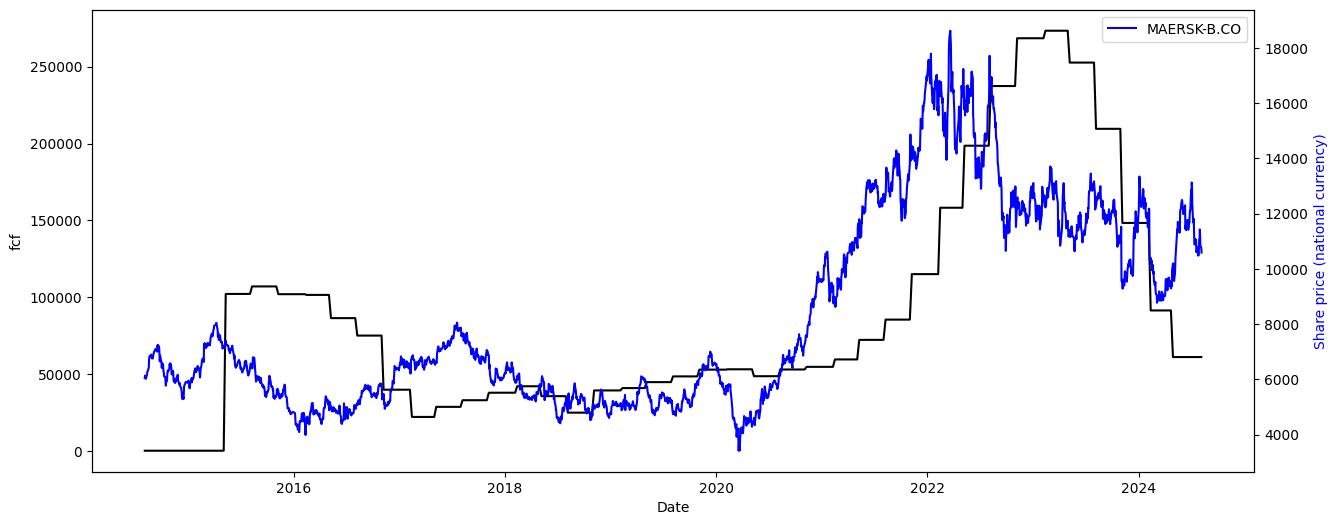

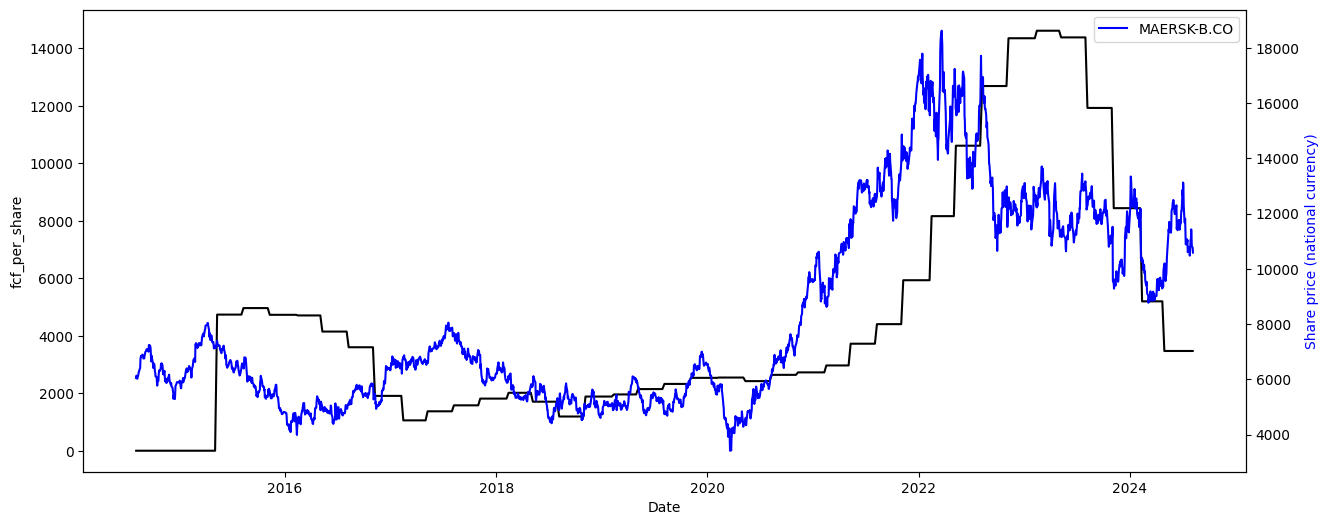

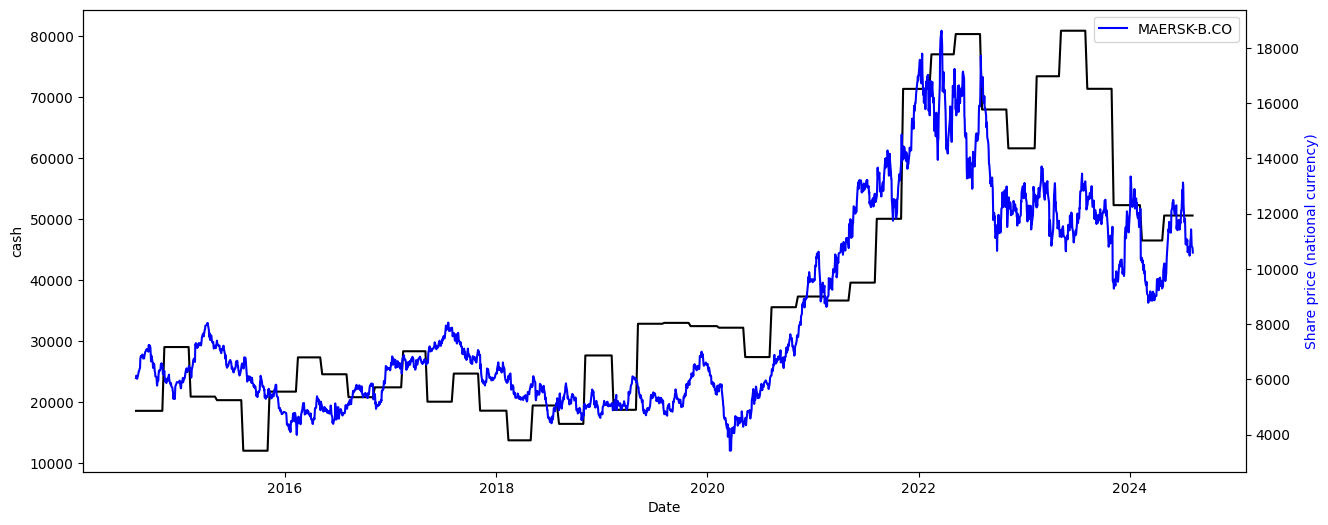

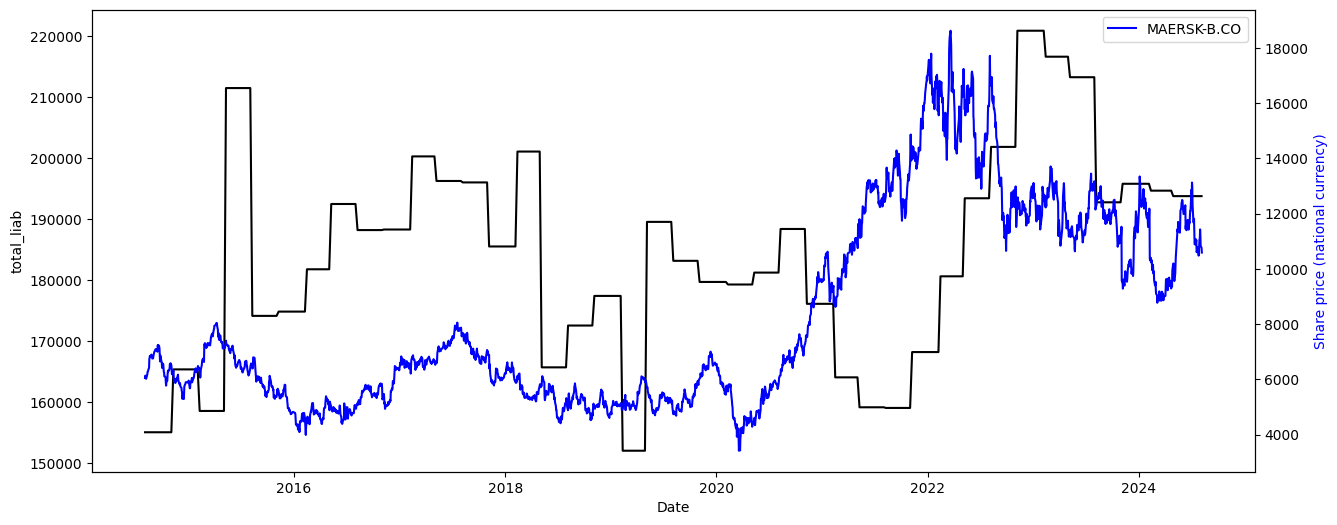

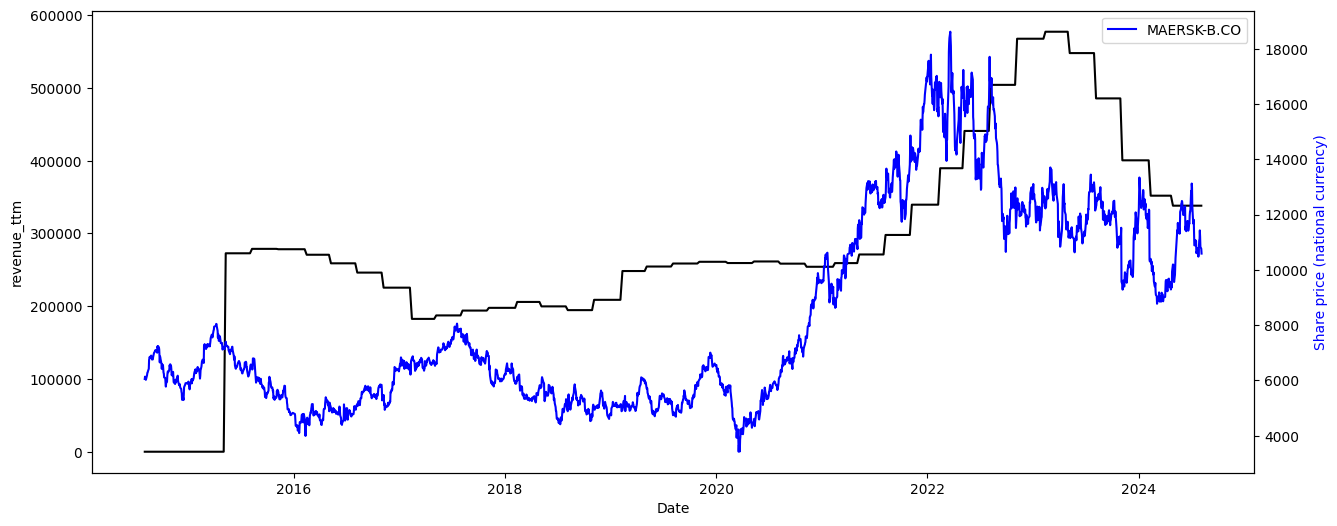

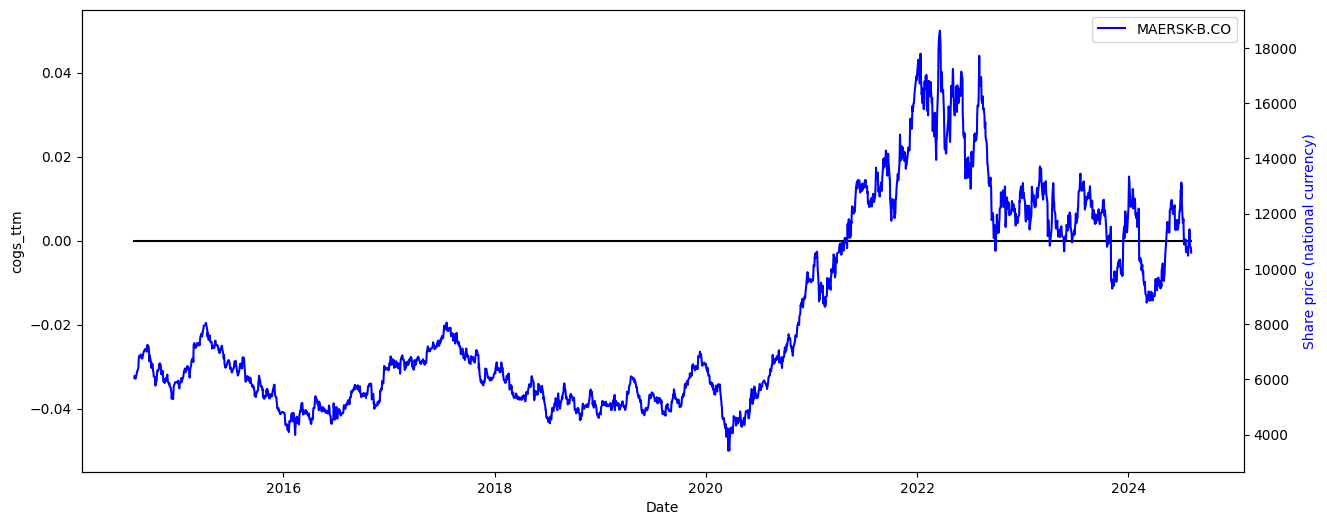

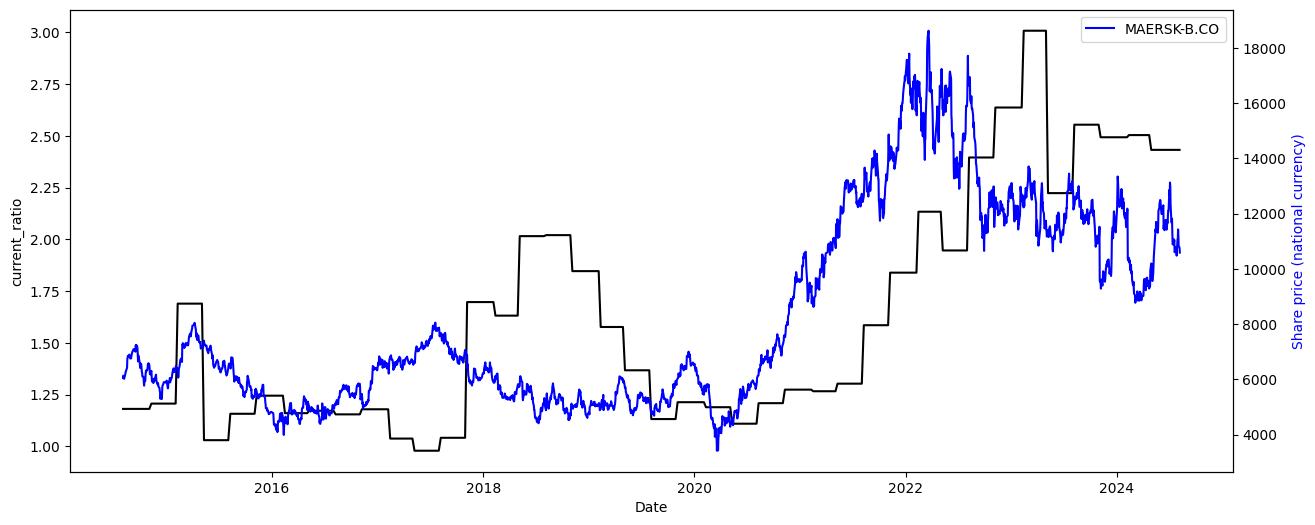

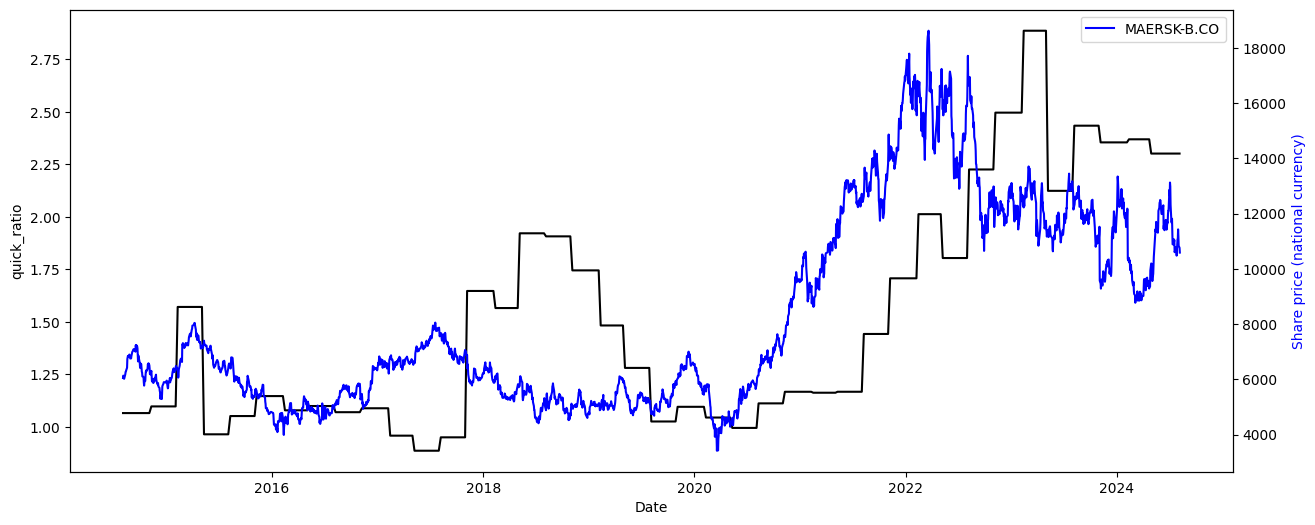

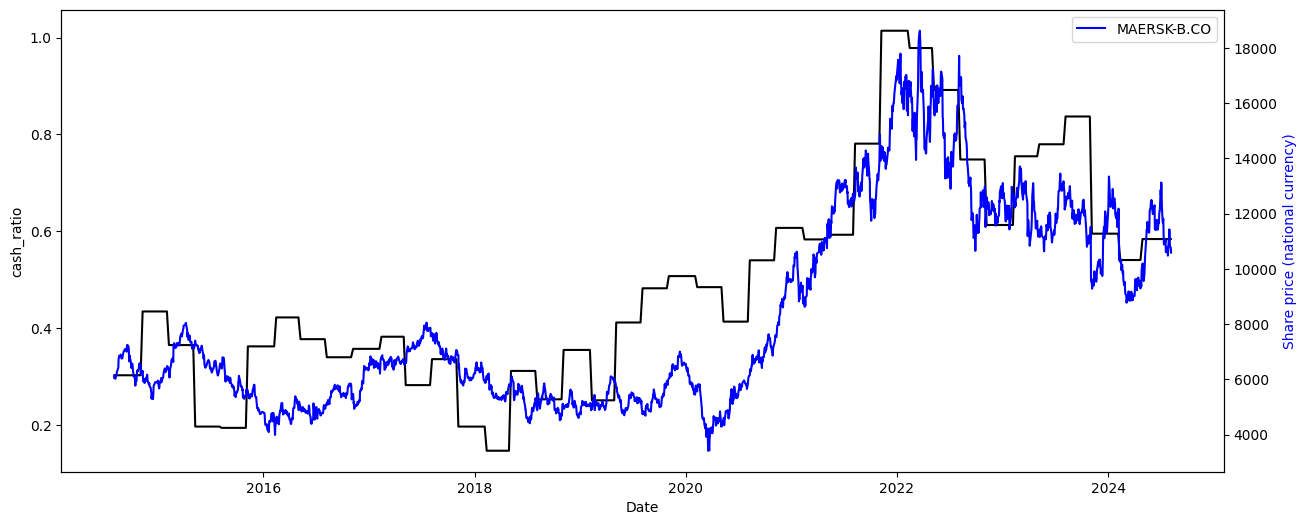

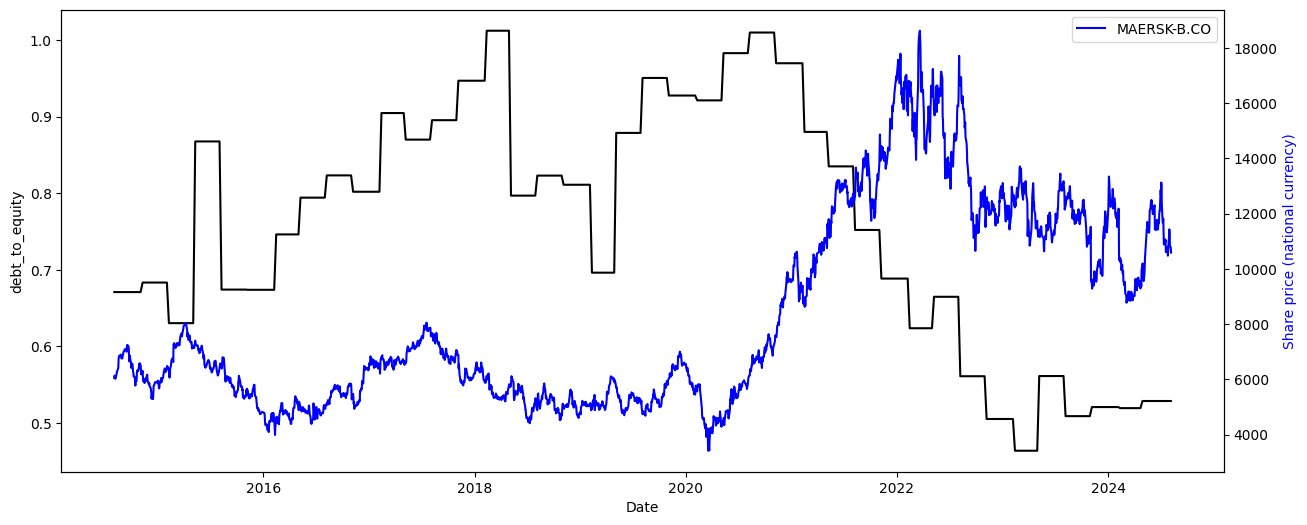

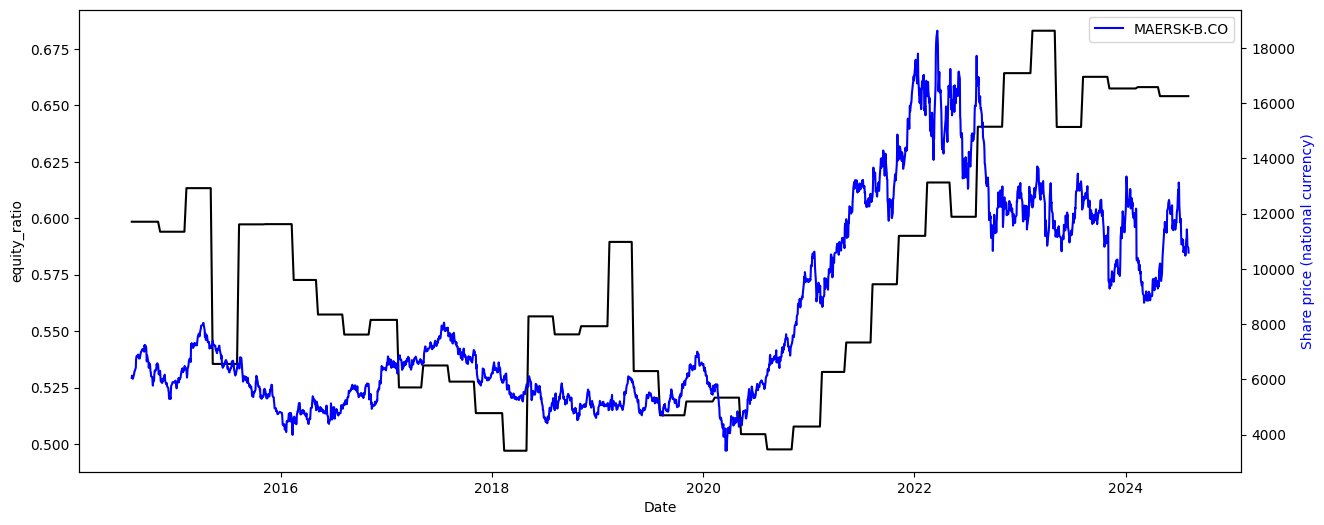

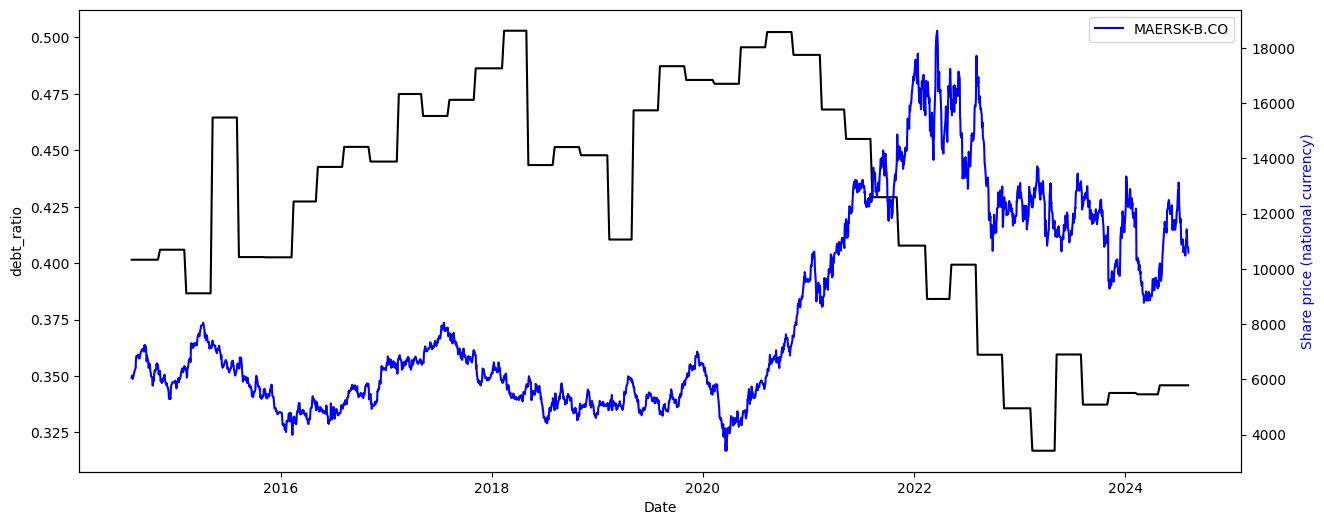

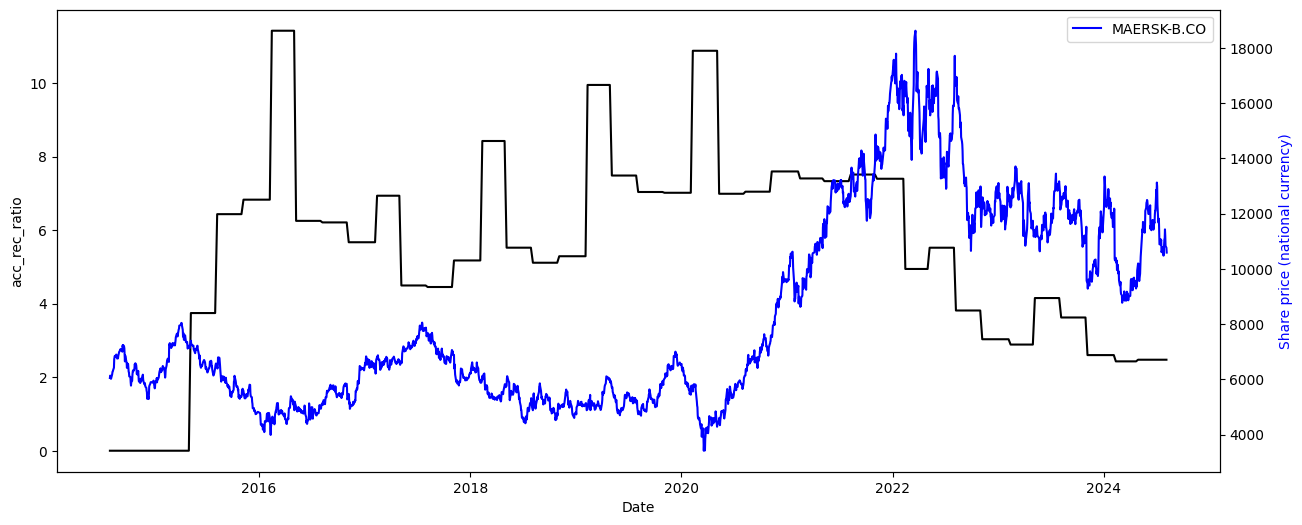

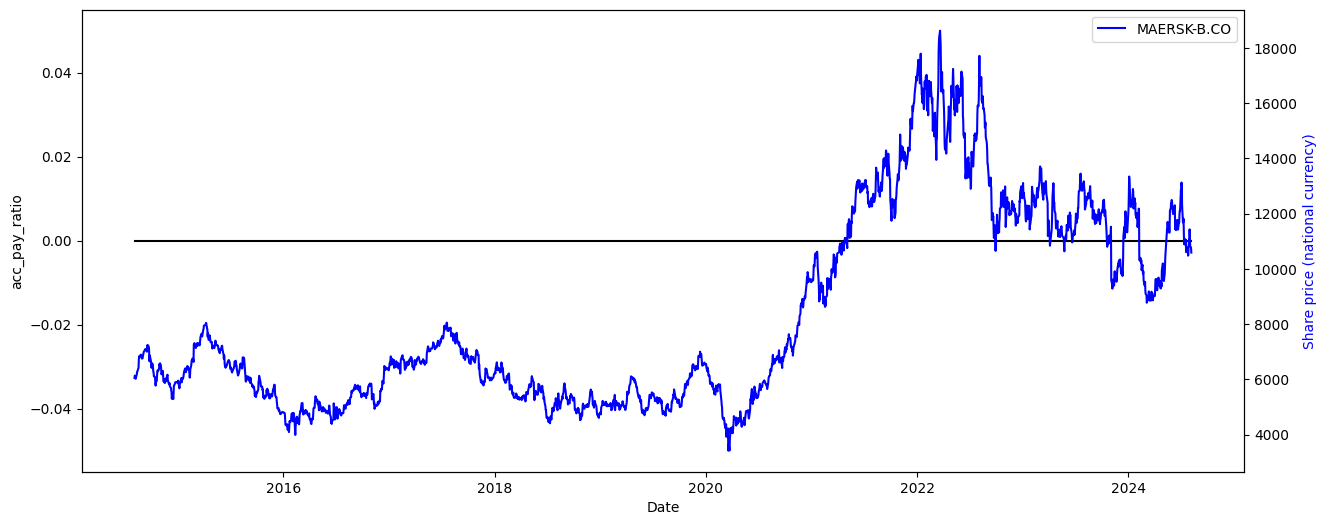

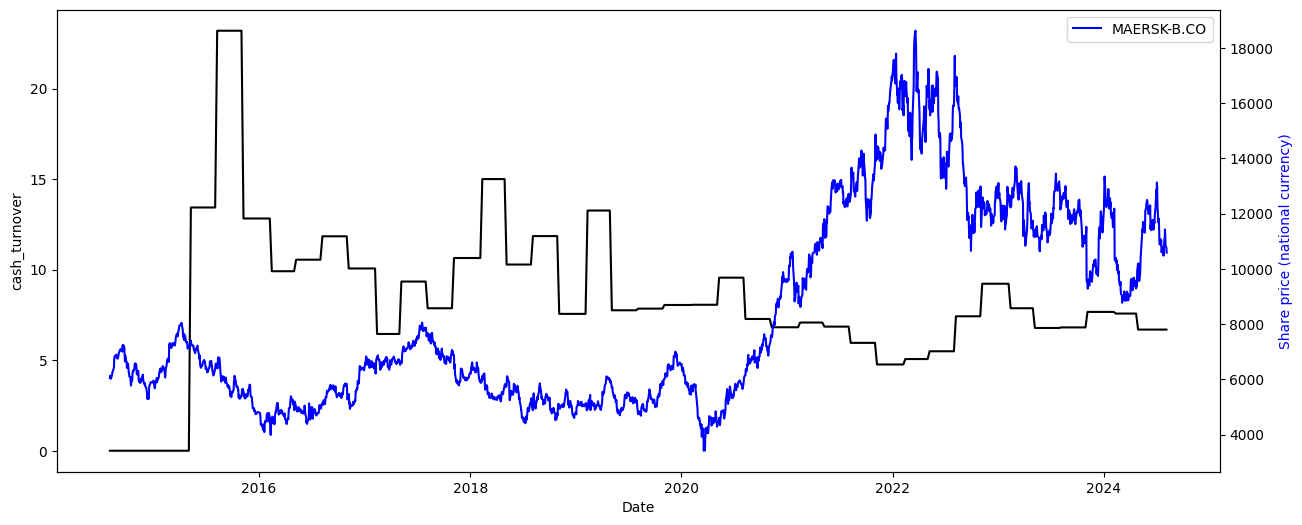

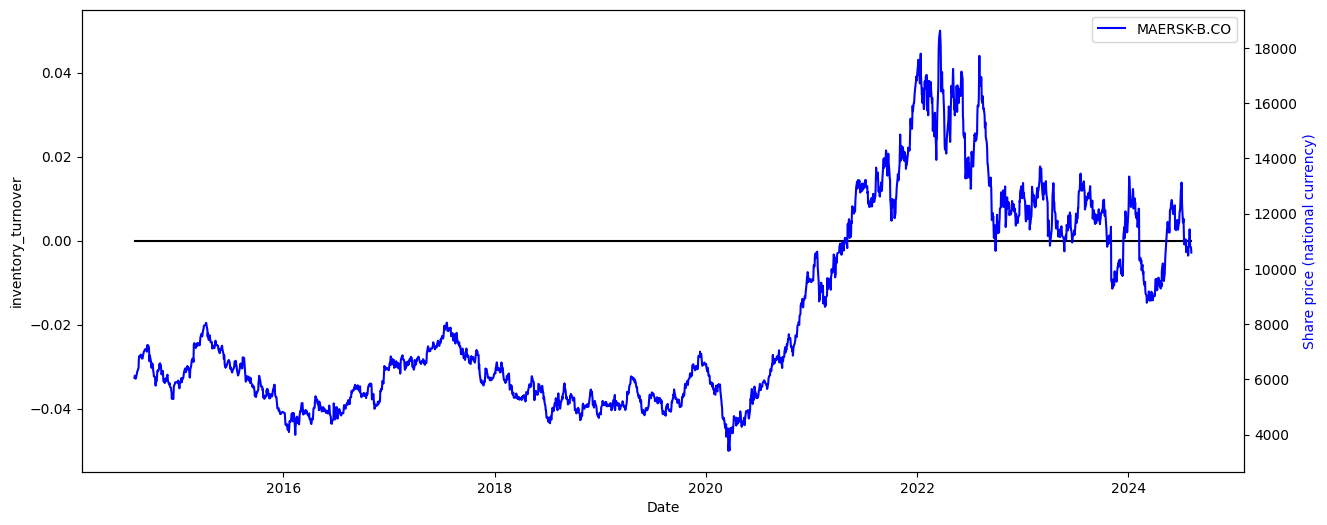

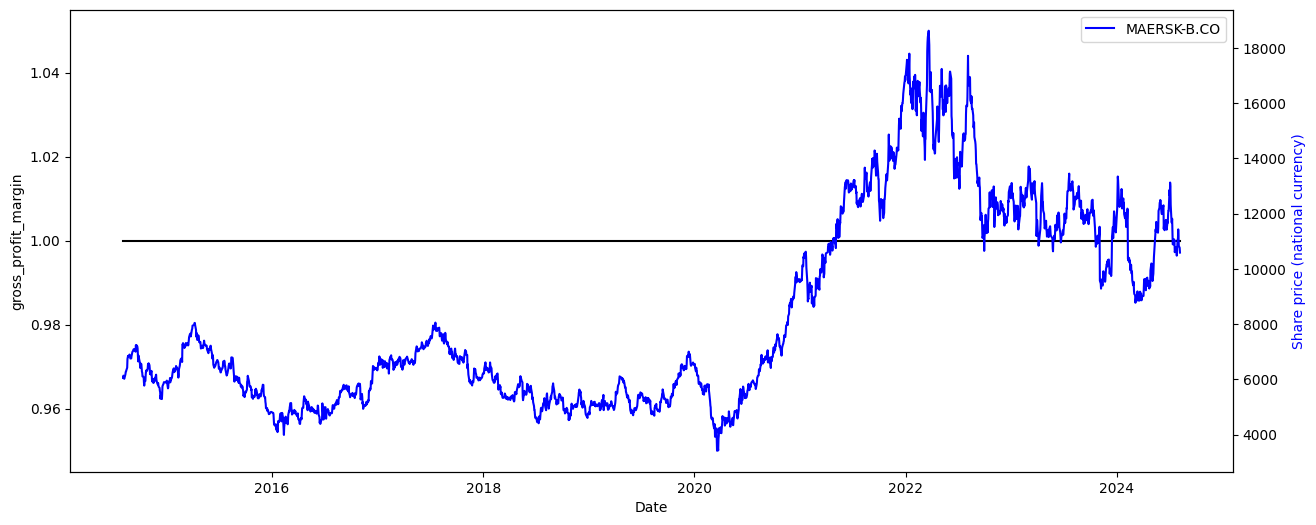

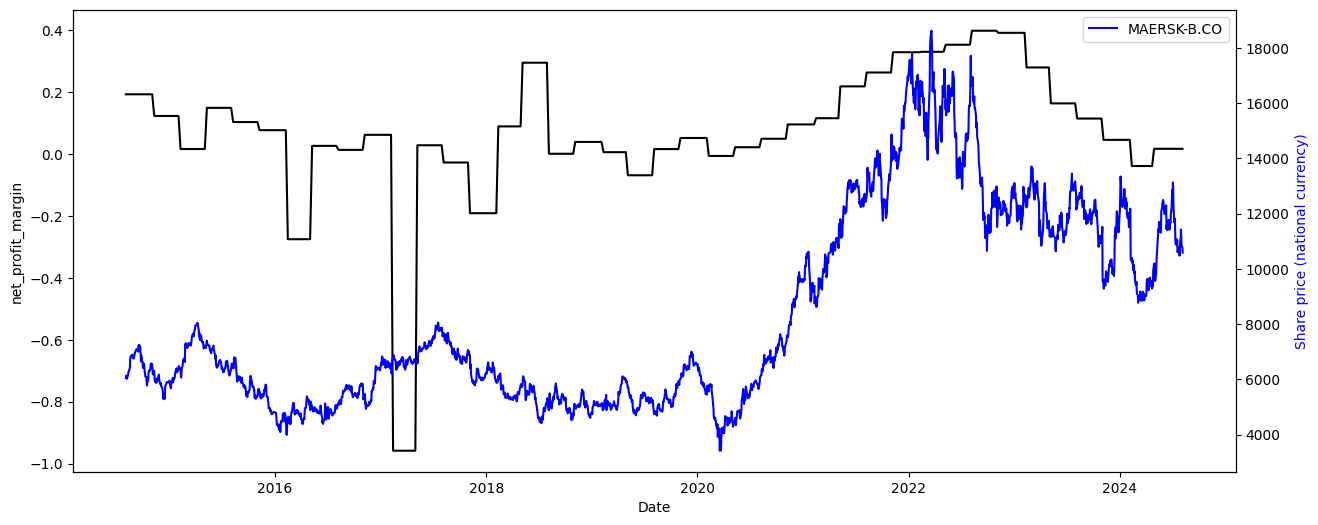

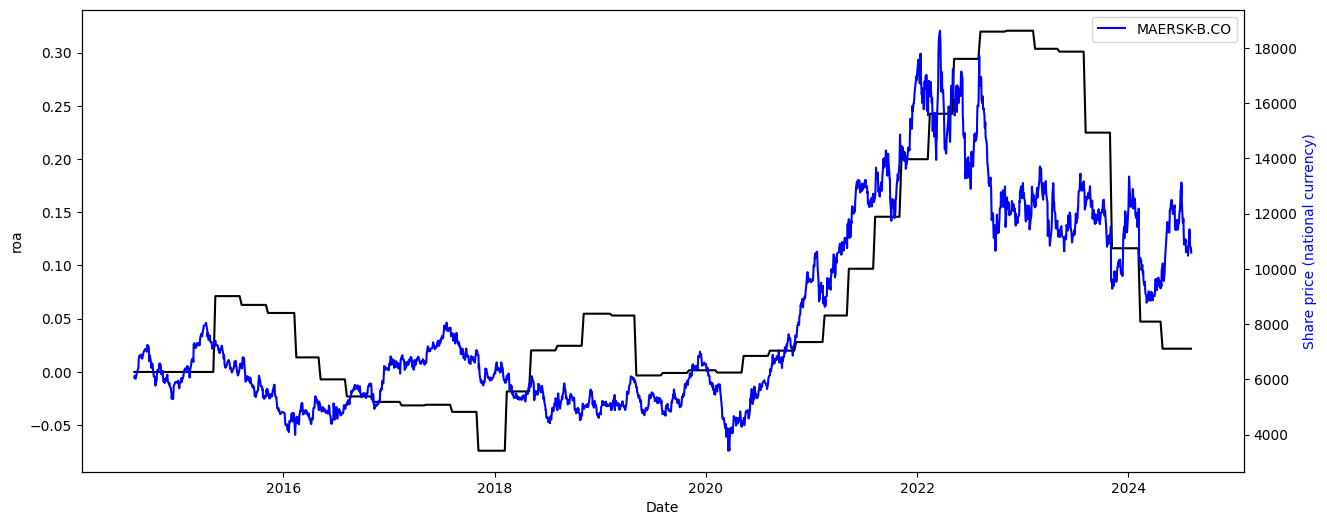

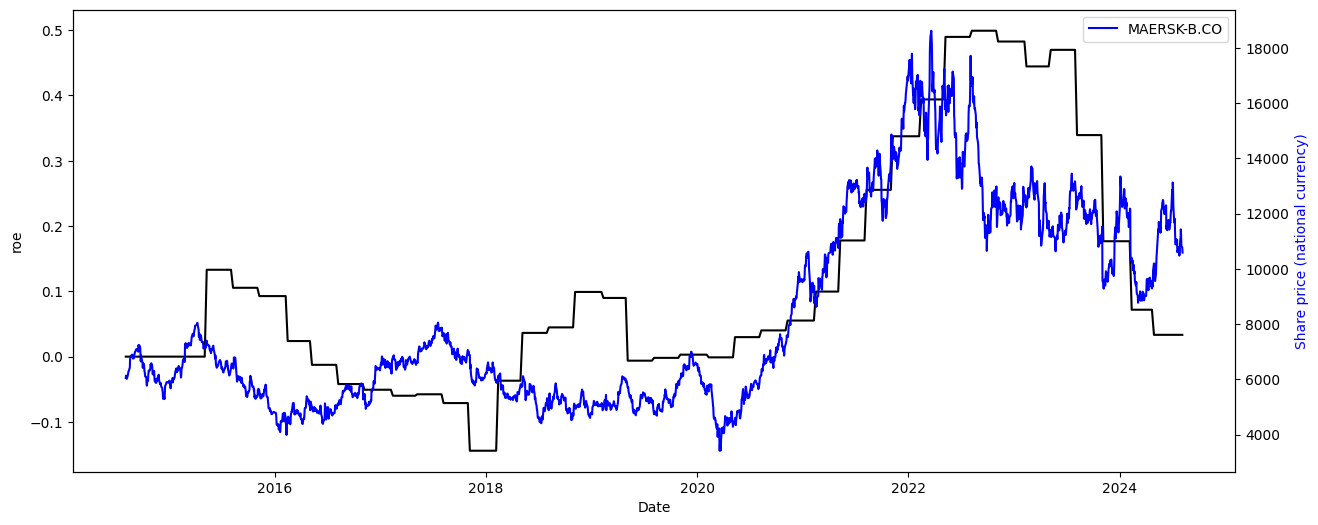

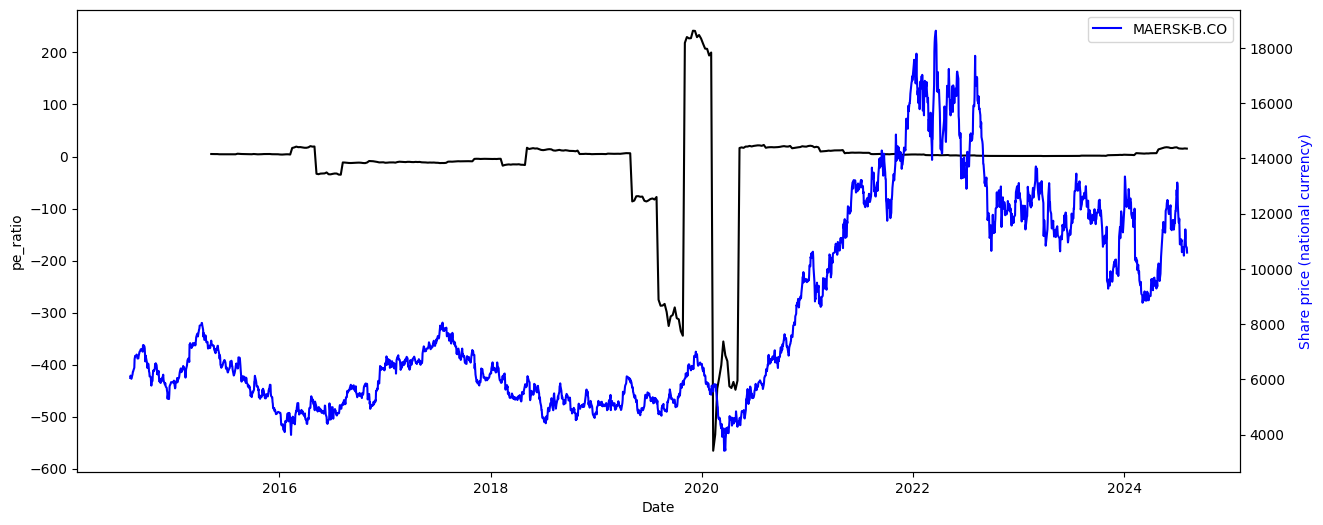

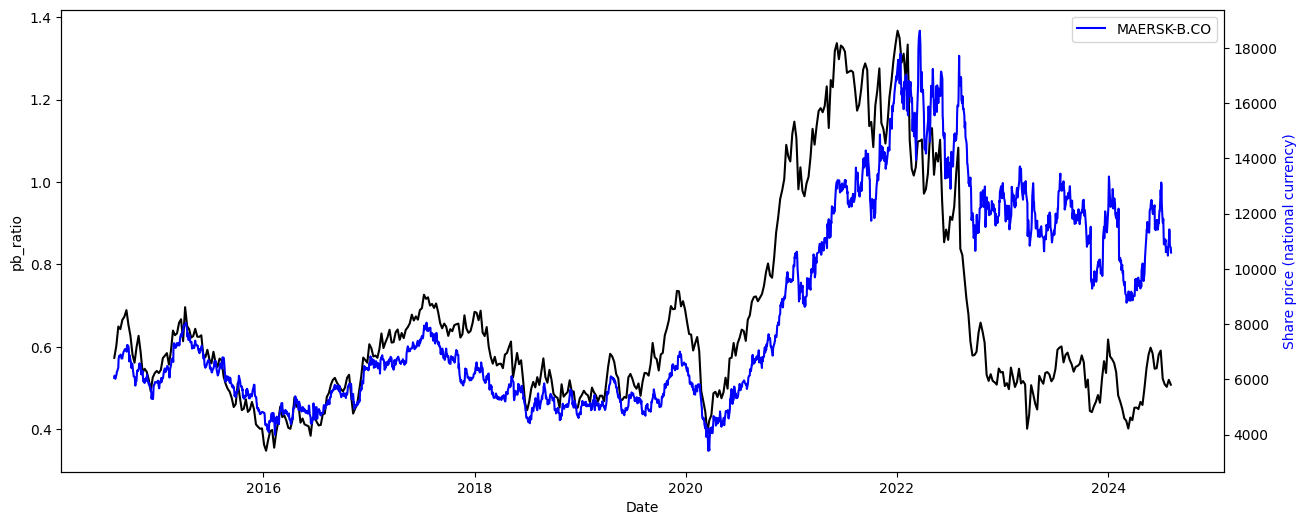

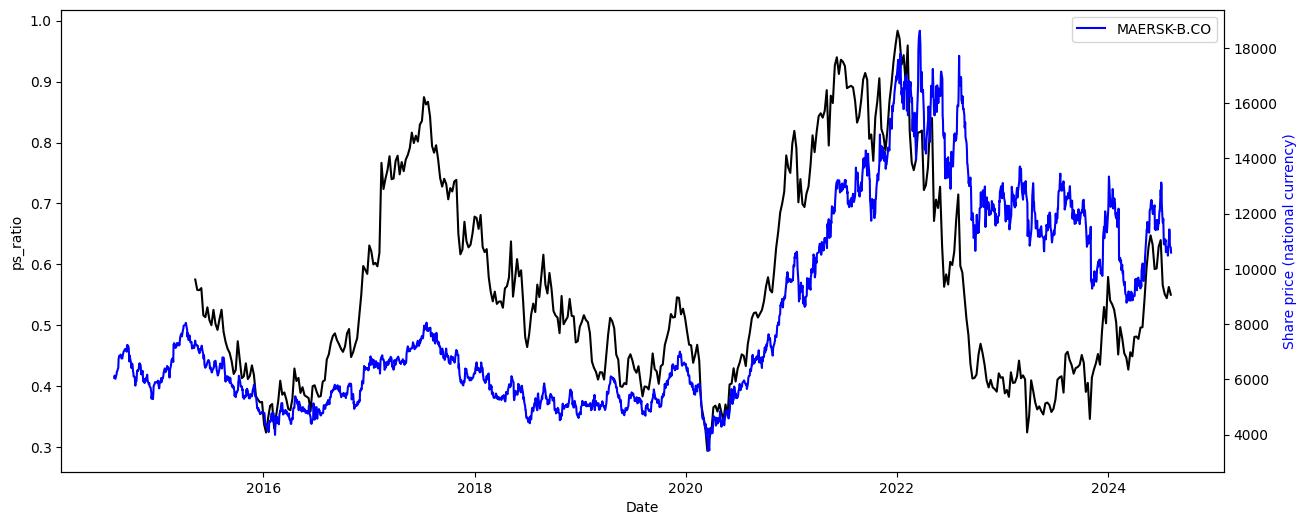

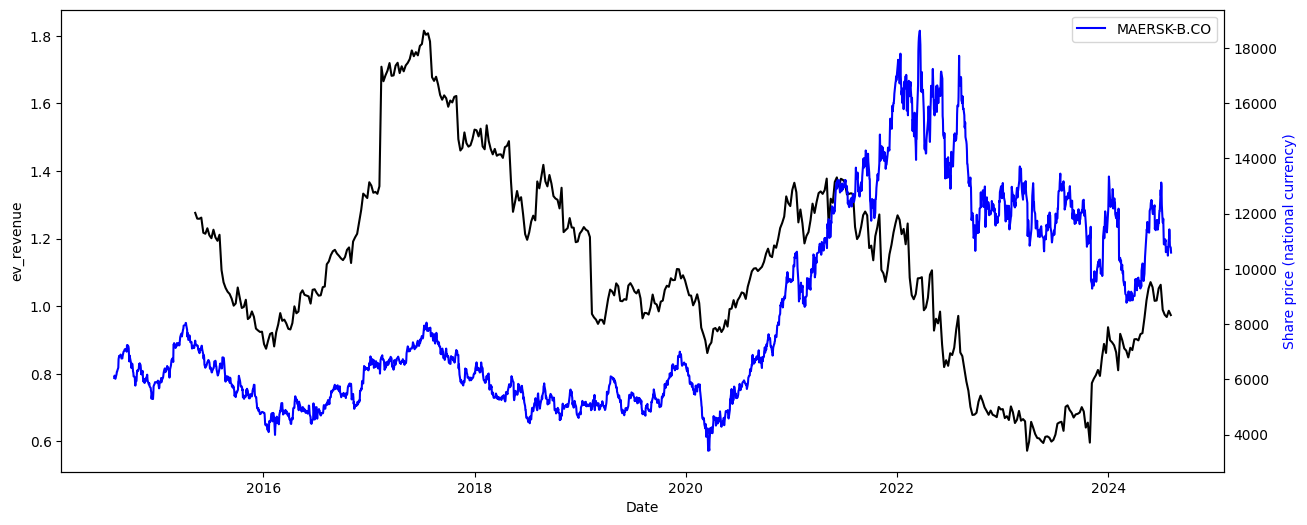

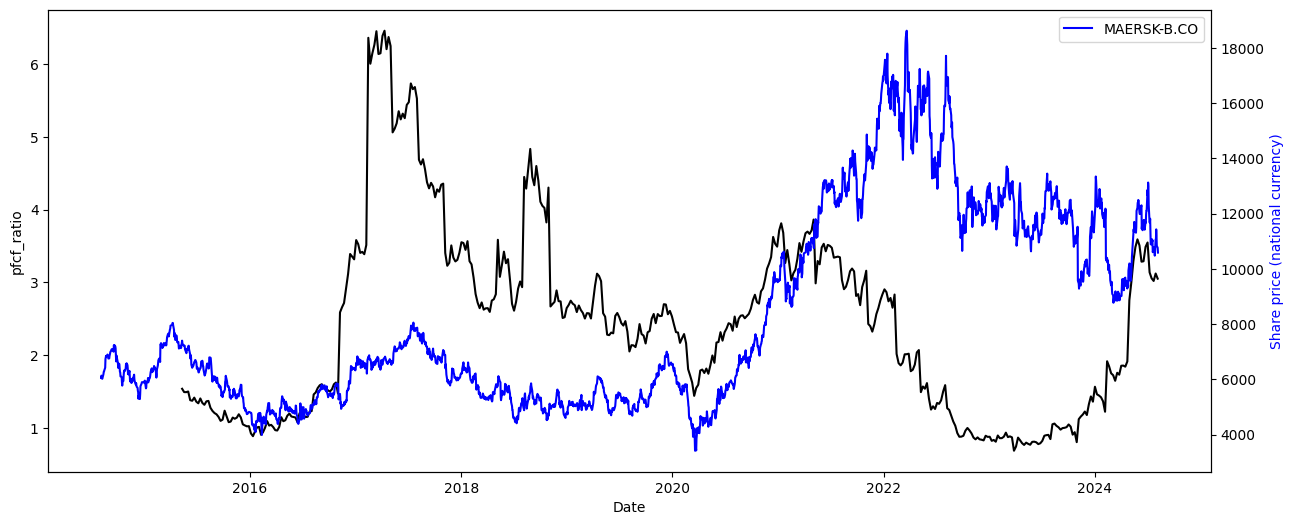

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

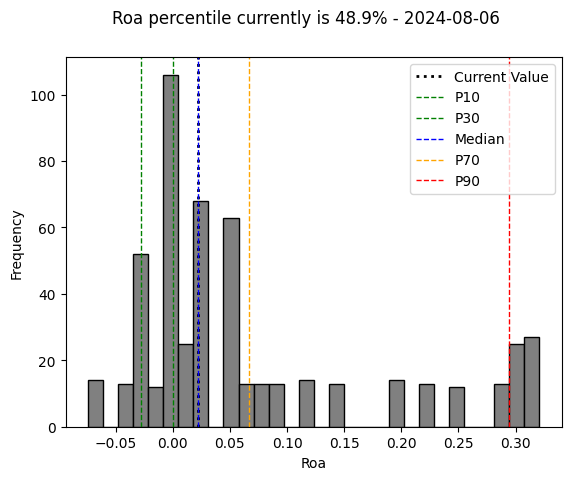

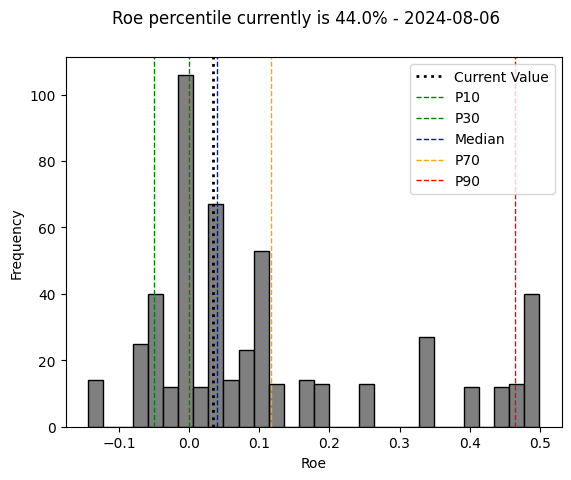

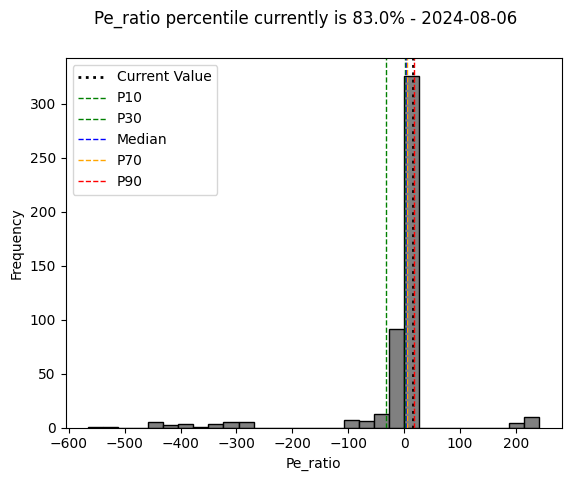

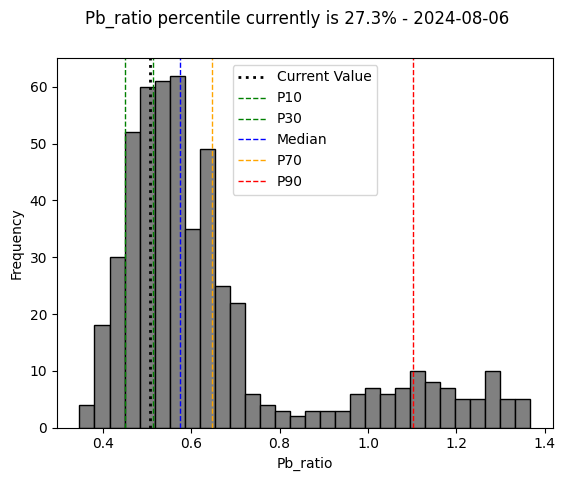

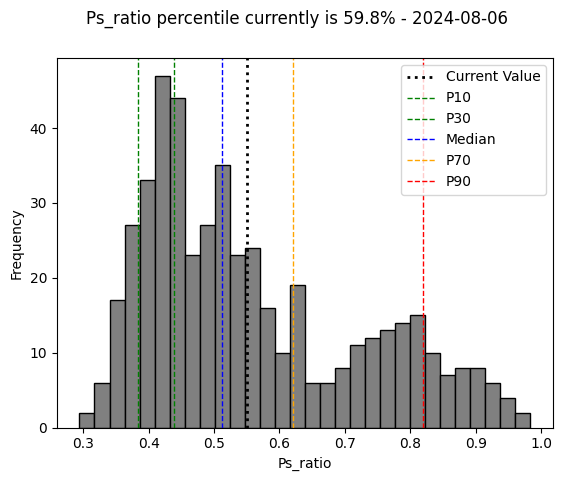

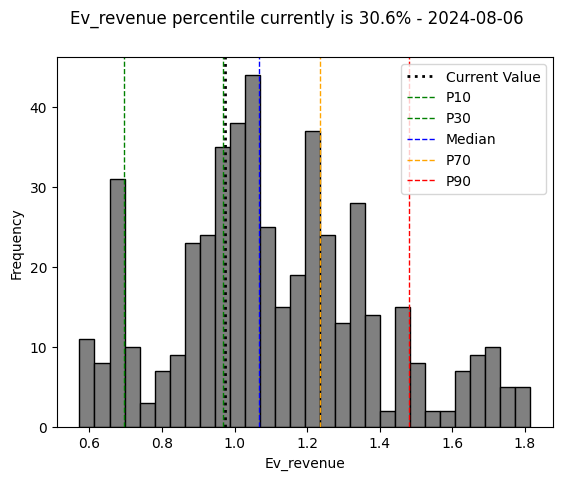

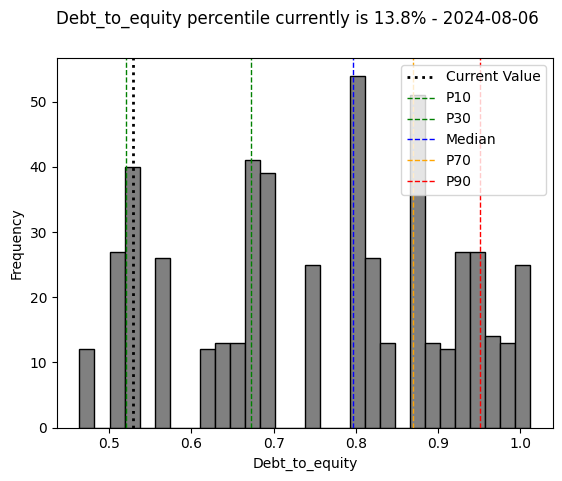

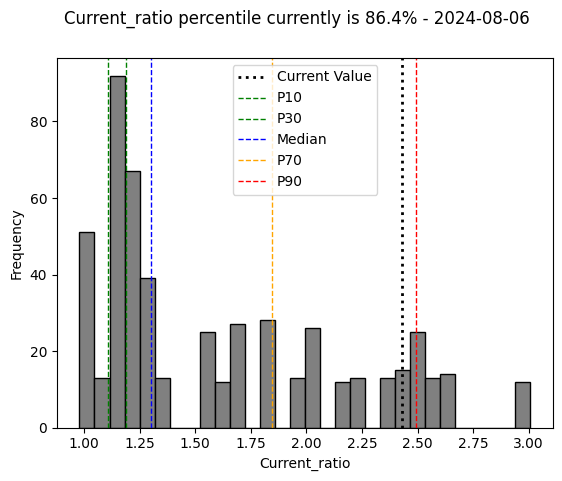

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.997201,0.128324,0.252576,-0.050479,-0.664637,-0.671590,0.700130
roe,0.997201,1.000000,0.132564,0.294681,-0.019676,-0.651982,-0.652556,0.672799
pe_ratio,0.128324,0.132564,1.000000,0.153279,0.206687,0.077939,-0.170250,0.155483
pb_ratio,0.252576,0.294681,0.153279,1.000000,0.852668,0.285675,0.148407,-0.072109
ps_ratio,-0.050479,-0.019676,0.206687,0.852668,1.000000,0.668080,0.223102,-0.174652
ev_revenue,-0.664637,-0.651982,0.077939,0.285675,0.668080,1.000000,0.676369,-0.580833
debt_to_equity,-0.671590,-0.652556,-0.170250,0.148407,0.223102,0.676369,1.000000,-0.760654
current_ratio,0.700130,0.672799,0.155483,-0.072109,-0.174652,-0.580833,-0.760654,1.000000


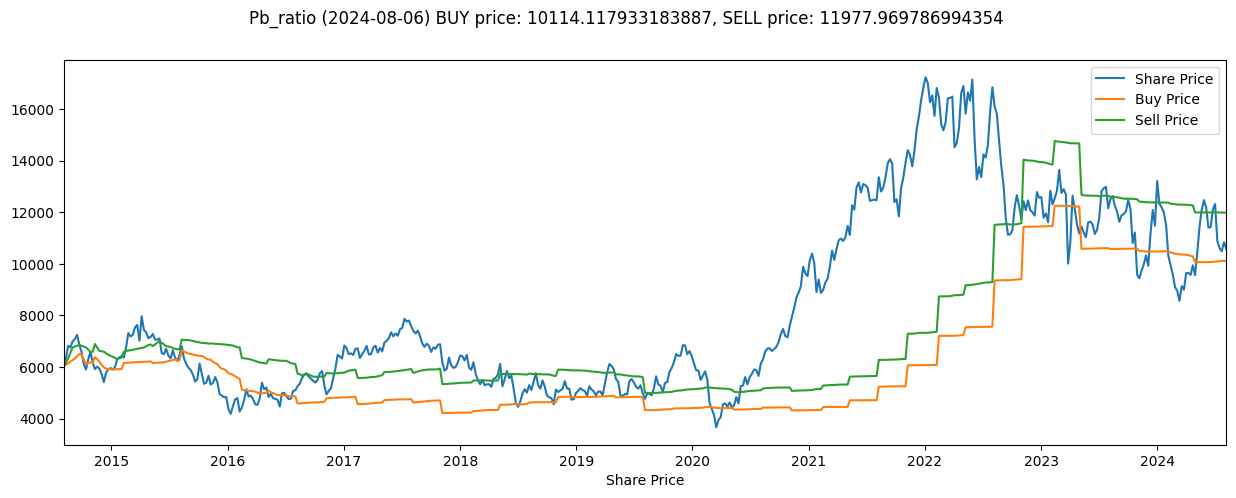

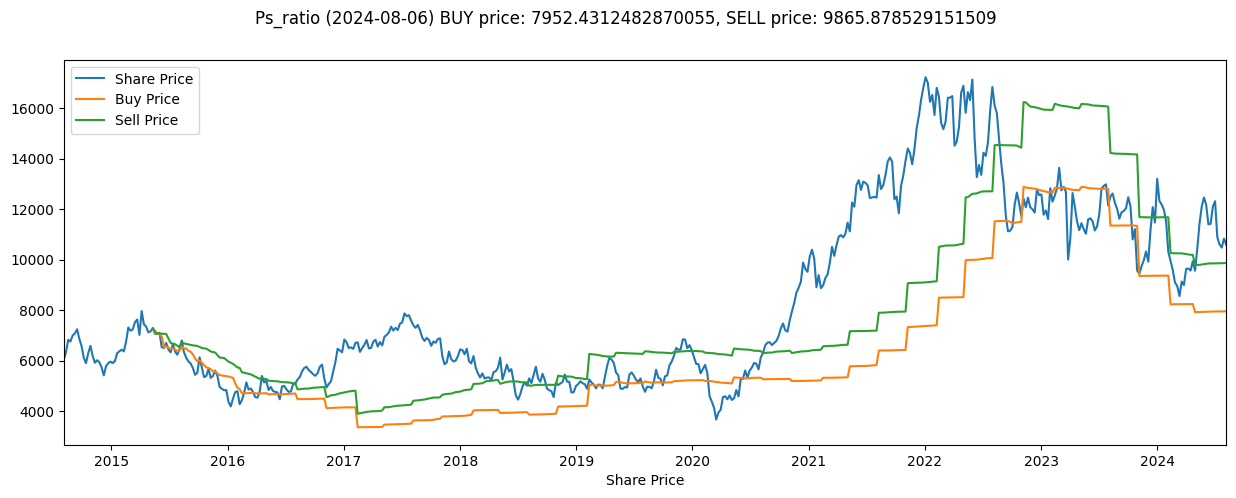

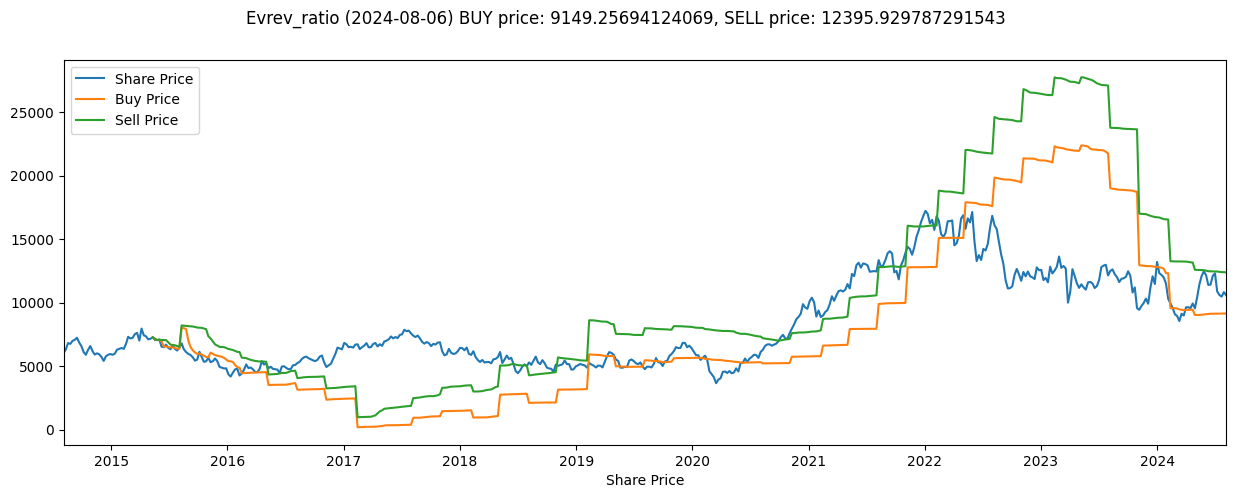

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)